In [54]:
import os

import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

import torchvision.models as models 
import torch.nn as nn

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
data_path = '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mixed3_100x100.pickle'

In [56]:
IMG_SIZE = 64 
IMG_NUM = 10000

def batch_normalize(imgs):
  return (imgs - np.min(imgs))/(np.max(imgs) - np.min(imgs))

def point_normalize(imgs):
  new_imgs = []
  for img in imgs:
    new_img =  batch_normalize(img)
    new_imgs.append(new_img)
  return np.asarray(new_imgs)


def preprocessing(X, Y, Y_sumphase, outputs = 2, norm_type = (0, 0)):
   # нормировка и изменение размера
    X= np.asarray(X)
    Y= np.asarray(Y)

    if norm_type[0] == 1:
      X =  batch_normalize(X)
    else:
      X =  point_normalize(X)

    if norm_type[1] == 1:
      Y_sumphase =  batch_normalize(Y_sumphase)
    else:
      Y_sumphase =  point_normalize(Y_sumphase)
    
    X_ = X.reshape(-1, outputs, IMG_SIZE,IMG_SIZE)
    Y_sumphase_ = Y_sumphase.reshape(-1,1,64,64)
    Y_ = Y
    X_train = torch.from_numpy(X_).float()
    y_train = torch.from_numpy(Y_).float()
    Y_sumphase_fin = torch.from_numpy(Y_sumphase_).float()
    return X_train, y_train, Y_sumphase_fin

def filter_good_idx(X):
  # отбираем только с хорошим индексом
  good_indx = []
  for i,x in enumerate(X):
    if np.sum(np.isnan(x))==0:
      good_indx.append(i)
  return good_indx

def get_traintest_data(path, outputs = 2, proportion = (0.9, 0.1, 0)):
  # получаем выборку
  with open(path, 'rb') as f:
      img1, img2, sum_phase, coeffs = pickle.load(f)
  img1 = img1.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
  img2 = img2.reshape(-1, 1, IMG_SIZE, IMG_SIZE)
  if outputs == 2:
    X = np.append(img1, img2, axis = 1)
  else:
    X = img1
    print(X.shape)
  y_coeffs = coeffs[:IMG_NUM]
  y_sum_phase = sum_phase[:IMG_NUM]
  X = X[:IMG_NUM]

  train_num, val_num, test_num = (int(IMG_NUM*proportion[0]),
                                  int(IMG_NUM*proportion[1]),
                                  int(IMG_NUM*proportion[2]))
  good_indx = filter_good_idx(y_coeffs)
  np.random.shuffle(good_indx)
  print(good_indx)
  X_train, y_train, y_train_sumphase =preprocessing(X[good_indx][:train_num], 
                                  y_coeffs[good_indx][:train_num], 
                                  y_sum_phase[good_indx][:train_num],
                                  outputs)

  X_val, y_val, y_val_sumphase =preprocessing(X[good_indx][train_num:train_num+val_num],
                              y_coeffs[good_indx][train_num:train_num+val_num], 
                              y_sum_phase[good_indx][train_num:train_num+val_num], 
                              outputs)
  if test_num!=0:
    X_test, y_test, y_test_sumphase =preprocessing(X[good_indx][train_num+val_num:train_num+val_num+test_num],
                              y_coeffs[good_indx][train_num+val_num:train_num+val_num+test_num],
                              y_sum_phase[good_indx][train_num:train_num+val_num], 
                               outputs)
    return (X_train, y_train, y_train_sumphase,
            X_val, y_val, y_val_sumphase,
            X_test, y_test,y_test_sumphase)

  return (X_train, y_train,y_train_sumphase,
          X_val, y_val, y_val_sumphase)

In [57]:
import pickle
X_train, y_train, _, X_val, y_val, _ = get_traintest_data(data_path, outputs = 2)

[9150, 89, 9910, 5586, 1843, 8737, 6490, 3781, 9853, 2872, 1335, 2726, 7721, 7652, 3325, 6268, 847, 7046, 6475, 7852, 5673, 9327, 8788, 3506, 9916, 9810, 2738, 3524, 2684, 3291, 1777, 3055, 3227, 7920, 5028, 9705, 2652, 9497, 6595, 7950, 9520, 5216, 3027, 8590, 5946, 1873, 9538, 6641, 3605, 1022, 8002, 860, 8851, 4512, 5725, 5740, 2928, 6292, 3977, 1834, 9502, 4257, 674, 2682, 8271, 9648, 9033, 8332, 8553, 7497, 4215, 6417, 301, 7678, 7743, 4017, 1076, 8014, 2552, 3014, 4171, 2627, 6158, 1219, 6673, 7283, 1067, 969, 8476, 4404, 1285, 1597, 9980, 2781, 6333, 767, 134, 3437, 7643, 7640, 3115, 8371, 4392, 2200, 8403, 6903, 3088, 8757, 2897, 1214, 9169, 6351, 1917, 1181, 8581, 8290, 3003, 9515, 1762, 8602, 788, 6666, 8410, 4839, 8107, 8329, 5330, 6516, 426, 5217, 1781, 8149, 1362, 7956, 9612, 6182, 5339, 5210, 6753, 7756, 7948, 5893, 8267, 1354, 8246, 5246, 7940, 2317, 3210, 7930, 2751, 4063, 9252, 4894, 8679, 5547, 8472, 3472, 1927, 6828, 7365, 8201, 2537, 4058, 7512, 7553, 7252, 9516, 56

In [58]:
y_train.shape

torch.Size([9000, 30])

In [59]:
X_train.shape

torch.Size([9000, 2, 64, 64])

In [60]:
resnet50 = models.resnet50(pretrained=False)
resnet50.conv1 = nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet50.fc = nn.Linear(in_features=2048, out_features=30, bias=True)

In [61]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [62]:
resnet50 = resnet50.to(device)

In [63]:
iters = []
train_losses = []
val_losses = []
lr = []


In [65]:
loss_f = nn.MSELoss()
optim = torch.optim.Adam(resnet50.parameters(), lr=10**(-6))

In [66]:
last_epoch = 0

In [23]:
!pip install wandb

In [67]:
import wandb

In [68]:
wandb.init(project='Resnet50')

epoch,44
loss,0.15061
val-loss,0.17424
_runtime,1355
_timestamp,1629389063
_step,43


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val-loss,██▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [69]:

it = 0

min_loss = np.inf
X_val_batch = X_val.to(device)[:64]
y_val_batch = y_val.to(device)[:64]
batch_size = 64
val_batch_size = 32
resnet50.train()
for epoch in range(last_epoch,300):
      order = np.random.permutation(len(X_train))
      loss = 0.
      for start_index in range(0, len(X_train), batch_size):
          optim.zero_grad()
          batch_indexes = order[start_index:start_index+batch_size]
          X_batch = X_train[batch_indexes].to(device)
          y_batch = y_train[batch_indexes].to(device)

          preds = resnet50.forward(X_batch)

          loss_value = torch.sqrt(loss_f(preds, y_batch))
          loss+=loss_value
          loss_value.backward() 

          optim.step()
      if epoch%2 == 0:      
          order = np.random.permutation(len(X_val))
          val_loss = 0.
          for start_index in range(0, len(X_val), val_batch_size):
              optim.zero_grad()
              batch_indexes = order[start_index:start_index+val_batch_size]
              X_val_batch = X_val[batch_indexes].to(device)
              y_val_batch = y_val[batch_indexes].to(device)

              preds_val = resnet50.forward(X_val_batch)

              loss_value_val = torch.sqrt(loss_f(preds_val, y_val_batch))
              val_loss+=loss_value_val
      coef_train =  len(X_train)/batch_size
      coef_val = len(X_val)/val_batch_size
      train_losses.append(loss/coef_train)
      val_losses.append(val_loss/coef_val )
      
      print("EPOCH - %d, train loss - %f, val loss - %f"%(epoch, loss/coef_train,val_loss/coef_val ))
      wandb.log({'epoch': epoch+1, 'loss': loss/coef_train,'val-loss': val_loss/coef_val})
      last_epoch = epoch
   
model.eval()
val_loss = get_loss(val_dl, resnet50)
if val_loss < min_loss:
    torch.save(resnet50.state_dict(), bst_model_fpath)

RuntimeError: ignored

In [28]:
import datetime
model_name ="mse_resnet_%d_%d_%d_%d"%(datetime.datetime.now().day,
                                                  datetime.datetime.now().month,
                                                  datetime.datetime.now().hour,
                                                  datetime.datetime.now().minute)

In [29]:
%%time

resnet50.forward(X_batch[:1])

CPU times: user 17.8 ms, sys: 865 µs, total: 18.7 ms
Wall time: 19.4 ms


tensor([[-0.0605,  0.2083,  0.1195,  0.2049,  0.1452, -0.1164,  0.0435, -0.0301,
          0.0667,  0.0359, -0.0368, -0.1559, -0.0585,  0.0631, -0.0531,  0.0370,
          0.0070, -0.1967, -0.0785, -0.0357,  0.1021,  0.1369, -0.1355,  0.0925,
          0.1094, -0.1456, -0.1857,  0.1097,  0.0091, -0.0118]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [30]:
!pip install soapy

     |████████████████████████████████| 558 kB 5.3 MB/s 
     |████████████████████████████████| 53 kB 2.4 MB/s 
     |████████████████████████████████| 2.6 MB 41.2 MB/s 
  Created wheel for soapy: filename=soapy-0.13.2-py3-none-any.whl size=680159 sha256=1334b8c1b044454a52fa13205e0a215d8a54e27eb1a54b3e4255ffd883ee93b7
  Stored in directory: /root/.cache/pip/wheels/29/d4/e6/d14f5151c3446422829c31d2944a1837e7e60afbf30514517f
  Created wheel for aotools: filename=aotools-1.0.4-py3-none-any.whl size=39047 sha256=2a849aae07b9fddb1a005139ac17b465df12921444fa3cf77be5b92866c3abff
  Stored in directory: /root/.cache/pip/wheels/84/b7/09/7ae0eb742ba851b93d3337c923cf01a2f2557fcb1dd7a6872f
Successfully built soapy aotools


In [31]:
import soapy
sim = soapy.Sim("/content/gdrive/My Drive/AO_prediction/conf/sh_8x8.yaml")
from soapy import confParse, atmosphere

config = confParse.loadSoapyConfig("/content/gdrive/My Drive/AO_prediction/conf/sh_8x8.yaml")

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [32]:
sim.aoinit()
atmosphere = atmosphere.atmos(config)

Starting Sim: 2021-08-19-16-04-54
Pixel Scale: 12.50 pxls/m
subScreenSize: 140 simulation pixels
Creating mask...
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise Infinite Phase Screen 3
Initialise Infinite Phase Screen 4
Initialising WFSs....
WFS 0: 104 measurements
Initialising 2 DMs...
Making DM Influence Functions...
DM 0: 2 active actuators
Making DM Influence Functions...
DM 1: 30 active actuators
32 total DM Actuators
Initialising Reconstructor...
Initialising 2 Science Cams...
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Generating fftw3 plan....
If this takes too long, change fftw_FLAGS.
Done!
Initialise Data Storage...
Initialisation Complete!
Turbulence summary @ 500 nm:
| r0 = 0.16 m (0.64" seeing)
| Vbar_5/3 = 11.78 m/s
| tau0 = 4.26 ms
Initialise Infinite Phase Screen 1
Initialise Infinite Phase Screen 2
Initialise

In [33]:
sim.makeIMat()

Making interaction Matrices...
Creating Interaction Matrix for DM 0 
2 of 2: Generating 2 Actuator DM iMat
Checking for redundant actuators...
DM 0 has 2 valid actuators (0 dropped)
Creating Interaction Matrix for DM 1 
30 of 30: Generating 30 Actuator DM iMat
Checking for redundant actuators...
DM 1 has 30 valid actuators (0 dropped)
Interaction Matrices Done
Creating Command Matrix
Invert iMat with conditioning: 0.0300
Command Matrix Generated!


In [34]:
result = resnet50.forward(X_batch[:2])

In [37]:
num = 0
predicted  = sim.dms[1].makeDMFrame(result[num].cpu().detach().numpy())
original = sim.dms[1].makeDMFrame(y_batch[num].cpu().detach().numpy())

predicted = (predicted - np.min(predicted))/(np.max(predicted) - np.min(predicted))
original = (original - np.min(original))/(np.max(original) - np.min(original))

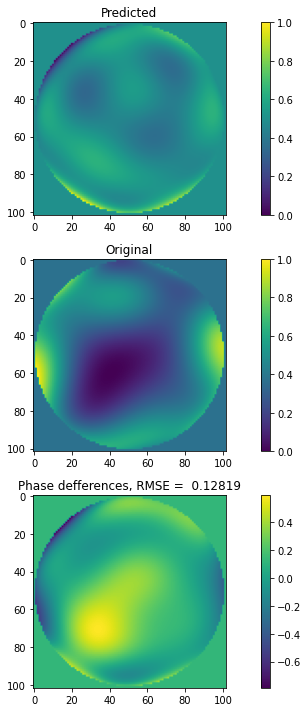

In [38]:
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.title("Predicted")
plt.imshow(predicted)
plt.colorbar()
plt.subplot(3,1,2)
plt.title("Original")
plt.imshow(original)
plt.colorbar()
plt.subplot(3,1,3)

plt.imshow(predicted-original)
loss_value = np.median((original -predicted )**2)**0.5
plt.title("Phase defferences, RMSE =  %.5f"%loss_value)
plt.colorbar()
plt.tight_layout()

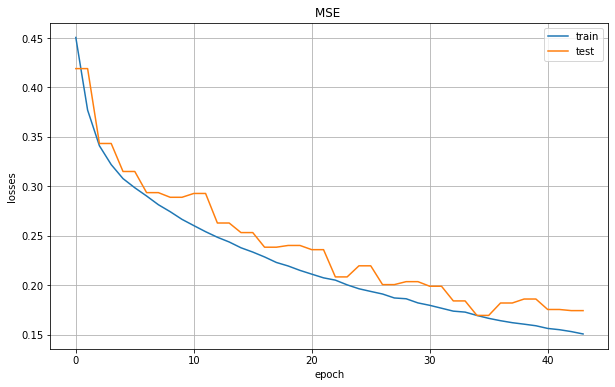

In [39]:

check_file_hist = os.path.exists('/content/gdrive/My Drive/ao_prediction/history')

check_file_model = os.path.exists('/content/gdrive/My Drive/ao_prediction/model')

if not check_file_hist:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/history")
if not check_file_model:
    os.mkdir("/content/gdrive/My Drive/ao_prediction/model")


plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="test")
plt.xlabel("epoch")
plt.ylabel("losses")
plt.title("MSE ")


plt.savefig("/content/gdrive/My Drive/ao_prediction/history/%s.png"%model_name)
plt.legend()
plt.grid()
torch.save(resnet50.state_dict(), "/content/gdrive/My Drive/ao_prediction/model/%s.torch"%model_name)


In [51]:
data_path = '/content/gdrive/My Drive/ao_prediction/data/data_pointstar_mono2.pickle'
X_test, y_test,_, X_test, y_test, _ = get_traintest_data(data_path, outputs = 2)

[3620, 9049, 441, 6952, 5707, 609, 2864, 9527, 1245, 6395, 3763, 5399, 1065, 5554, 1910, 36, 617, 5614, 3613, 8534, 1502, 4242, 7359, 184, 6149, 8731, 7334, 4621, 9841, 85, 341, 9989, 7791, 113, 1057, 8311, 4562, 7999, 8250, 3144, 2101, 365, 3735, 2995, 3732, 949, 3347, 190, 7360, 3785, 9193, 7127, 4976, 1943, 1476, 4227, 62, 296, 2055, 4591, 7931, 9162, 2018, 5744, 7705, 3682, 6347, 1884, 8500, 438, 7019, 576, 5480, 9185, 5426, 1242, 7138, 4461, 119, 241, 3926, 2841, 3997, 9276, 269, 1520, 8258, 5286, 8042, 7727, 323, 1882, 6115, 9044, 7305, 7421, 2703, 4417, 1307, 2130, 4280, 8973, 5902, 7789, 3555, 6873, 655, 8724, 665, 5465, 1060, 934, 9875, 22, 3564, 5774, 5084, 4737, 9104, 8418, 4671, 5439, 6466, 2937, 5209, 7913, 4835, 7910, 6232, 6262, 1166, 8949, 2652, 9781, 503, 8386, 3367, 3864, 2378, 7442, 3446, 8340, 6176, 2673, 6860, 9666, 1208, 7731, 7098, 290, 5806, 4953, 5684, 1676, 676, 2100, 4663, 2619, 9123, 4831, 7684, 9339, 2626, 7491, 3077, 1739, 7602, 9553, 1947, 3335, 4594, 658

In [53]:
order = np.random.permutation(len(X_test))
test_batch_size = 32
test_loss = 0.
for start_index in range(0, len(X_test), test_batch_size):
    optim.zero_grad()
    batch_indexes = order[start_index:start_index+test_batch_size]
    X_test_batch = X_test[batch_indexes].to(device)
    y_test_batch = y_test[batch_indexes].to(device)

    preds_test = resnet50.forward(X_test_batch)

    loss_value_test = torch.sqrt(loss_f(preds_test, y_test_batch))
    test_loss+=loss_value_test
coef_test = len(X_test)/test_batch_size
print(test_loss/coef_test)

tensor(0.2856, device='cuda:0', grad_fn=<DivBackward0>)
